# **DOA Estimation Simulation**

This notebook demonstrates with multiple sources, snapshot averaging, and robust peak detection.

## **1. Import Libraries**

In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

plt.style.use('seaborn-v0_8')

## **2. Signal Model**

The received signal at an array of $M$ sensors with $K$ sources is:

$$
\mathbf{X}(t) = \mathbf{A}(\theta) \mathbf{S}(t) + \mathbf{N}(t)
$$

Where:
- $\mathbf{X}(t) \in \mathbb{C}^{M \times N}$ — received signal matrix (M sensors, N snapshots)
- $\mathbf{A}(\theta) \in \mathbb{C}^{M \times K}$ — steering matrix

$$
\mathbf{A}(\theta) =
\begin{bmatrix}
1 & 1 & \dots & 1 \\
e^{-j 2 \pi d \sin\theta_1} & e^{-j 2 \pi d \sin\theta_2} & \dots & e^{-j 2 \pi d \sin\theta_K} \\
\vdots & \vdots & \ddots & \vdots \\
e^{-j 2 \pi d (M-1) \sin\theta_1} & e^{-j 2 \pi d (M-1) \sin\theta_2} & \dots & e^{-j 2 \pi d (M-1) \sin\theta_K}
\end{bmatrix}
$$

- $\mathbf{S}(t) \in \mathbb{C}^{K \times N}$ — source signal matrix  
- $\mathbf{N}(t) \in \mathbb{C}^{M \times N}$ — additive noise

## **3. Parameters**

In [99]:
# Array and signal parameters
M = 32 # Number of sensors
d = 0.5 # Sensor spacing (Normalized to wavelength)
angles = np.array([5.0, 6.0, 30.0, 50.0, 77.0]) # Source DOAs (degrees)
num_sources = len(angles)

fs = 1000 # Sampling frequency
duration = 1 # Duration (seconds)
t = np.linspace(0, duration, int(fs*duration))  # Time vector

SNR_dB = 100 # Desired SNR at array (dB)

print(f"Number of sensors: {M}, Number of sources: {num_sources}, SNR: {SNR_dB} dB")

Number of sensors: 32, Number of sources: 5, SNR: 100 dB


## **4. Generate Source Signals (Sum of Sinusoids)**

In [100]:
def generate_source_signal(t, freqs_per_source=3, freq_range=(50, 500)):
    freqs = np.random.uniform(freq_range[0], freq_range[1], freqs_per_source)
    signal = np.sum([np.sin(2*np.pi*f*t) for f in freqs], axis=0)
    return signal

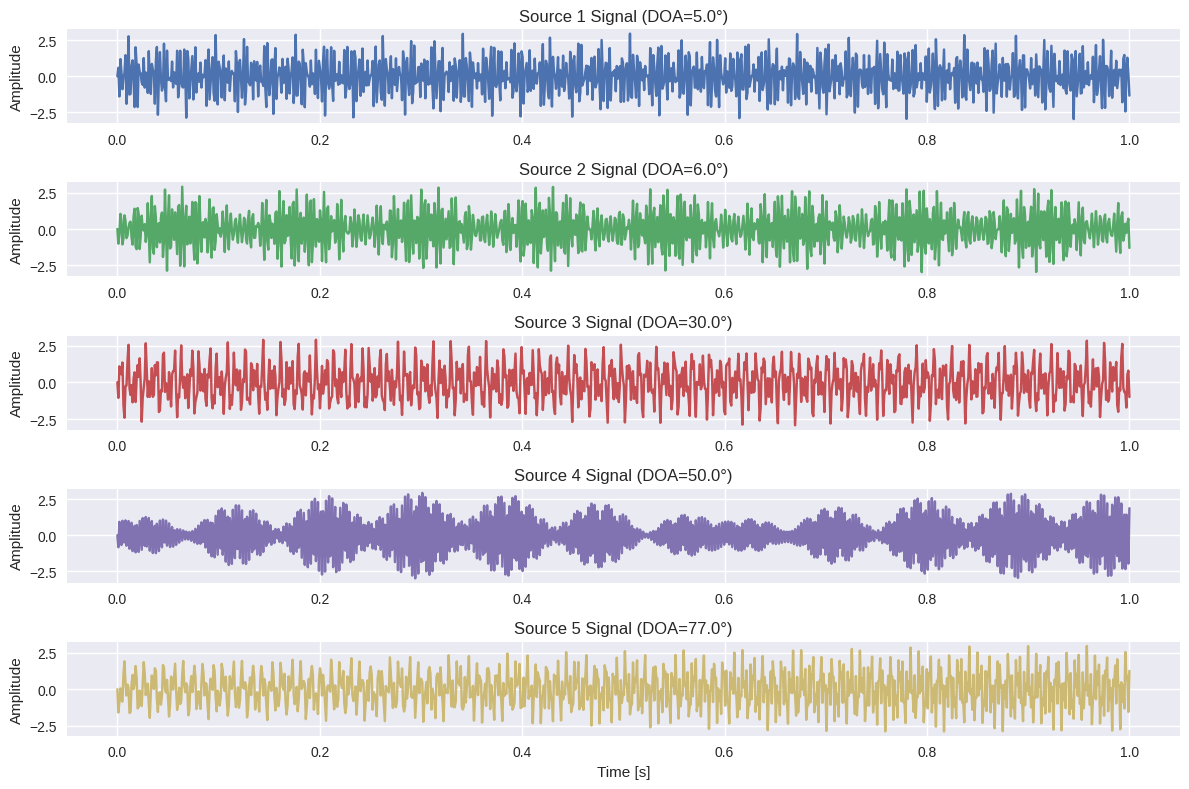

In [101]:
S = np.zeros((num_sources, len(t)))
for i in range(num_sources):
    S[i, :] = generate_source_signal(t, freqs_per_source=3, freq_range=(50, 900))

# Plot source signals
plt.figure(figsize=(12, 8))
for i in range(num_sources):
    plt.subplot(num_sources, 1, i+1)
    plt.plot(t, S[i], color=f'C{i}')
    plt.title(f"Source {i+1} Signal (DOA={angles[i]}°)")
    plt.ylabel("Amplitude")
    plt.grid(True)
plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

## **5. Steering Matrix and Received Signals**

In [102]:
# Steering matrix
A = np.zeros((M, num_sources), dtype=complex)
for i, angle in enumerate(angles):
    theta = np.deg2rad(angle)
    A[:, i] = np.exp(-1j * 2 * np.pi * d * np.arange(M) * np.sin(theta))

# Additive noise
signal_power = np.mean(np.abs(A @ S)**2)
noise_power = signal_power / 10**(SNR_dB/10)
N = np.sqrt(noise_power/2) * (np.random.randn(M, len(t)) + 1j * np.random.randn(M, len(t)))

# Received signals
X = A @ S + N

# Verify shapes
print("Steering matrix A:", A.shape)
print("Source signals S:", S.shape)
print("Noise N:", N.shape)
print("Received signals X:", X.shape)

Steering matrix A: (32, 5)
Source signals S: (5, 1000)
Noise N: (32, 1000)
Received signals X: (32, 1000)


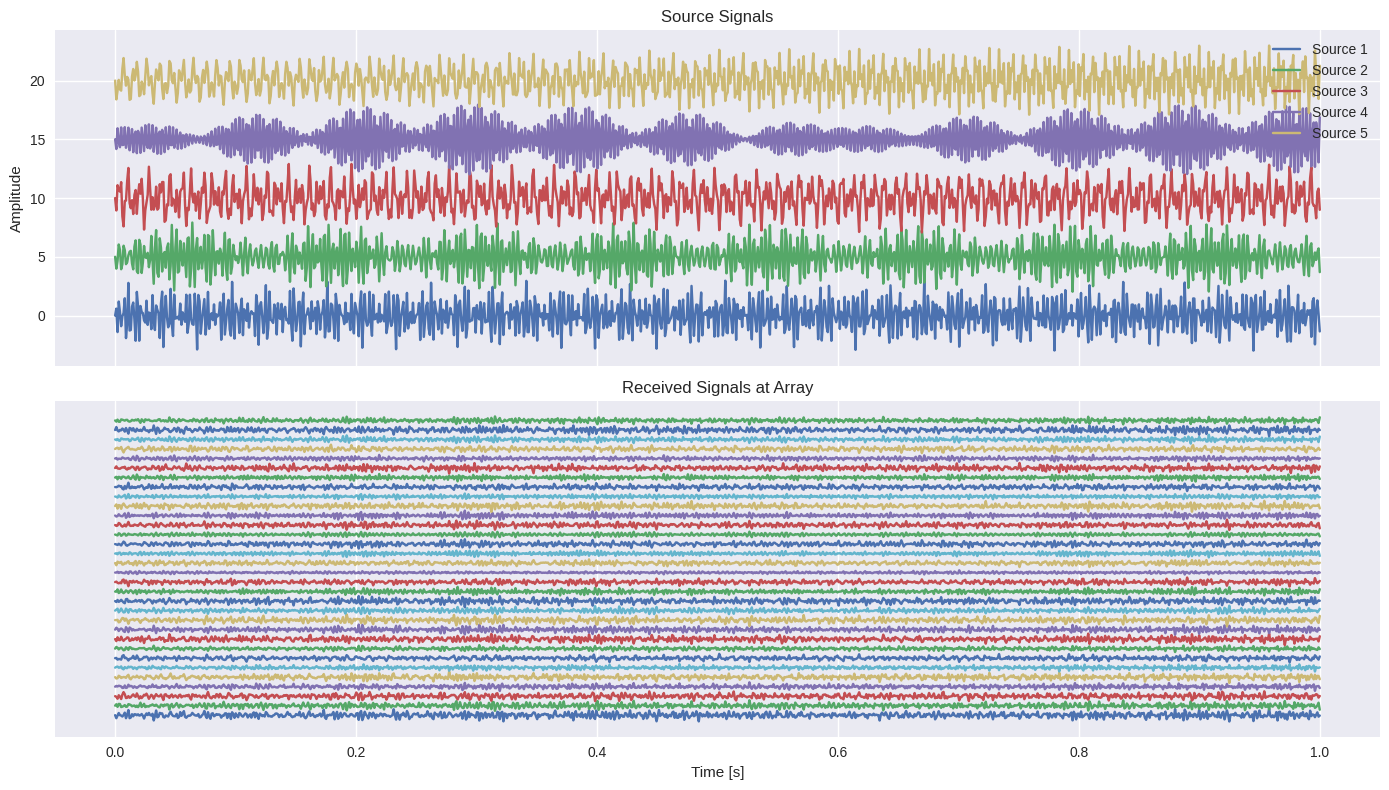

In [103]:
# Plot Received Signals
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Original sources (shifted for clarity)
for i in range(num_sources):
    axs[0].plot(t, S[i] + i*5, label=f"Source {i+1}")
axs[0].set_title("Source Signals")
axs[0].set_ylabel("Amplitude")
axs[0].legend()
axs[0].grid(True)

# Received array signals
offset = 1.5 * np.max(np.abs(X.real))
for m in range(M):
    axs[1].plot(t, X[m].real + m*offset, label=f"Sensor {m+1}")
axs[1].set_title("Received Signals at Array")
axs[1].set_xlabel("Time [s]")
axs[1].set_yticks([])
axs[1].grid(True)

plt.tight_layout()
plt.show()

## **6. Spatial Correlation Matrix**

$$
\mathbf{R}_{xx} = \frac{1}{N} \mathbf{X} \mathbf{X}^H
$$

In [104]:
Rxx = (X @ X.conj().T) / X.shape[1]
Rxx_df = pd.DataFrame(np.abs(Rxx))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(Rxx_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,7.606147,3.626832,2.526191,2.764711,3.064321,4.187111,3.919575,3.429855,2.701568,6.762329,3.289589,3.413705,3.704626,1.310483,4.100987,4.541338,4.432635,1.041045,4.749774,1.808610,4.657069,5.513932,1.030572,2.931023,3.572575,4.288716,0.794239,3.223842,1.287510,5.038166,6.139233,1.660537
1,3.626832,7.523852,3.558844,2.520369,2.726207,3.010879,4.161099,3.915113,3.385068,2.677168,6.662120,3.210063,3.424043,3.692220,1.284203,4.064849,4.508745,4.373902,0.997132,4.658949,1.736805,4.647634,5.480218,1.030158,2.890712,3.518968,4.218124,0.812094,3.182999,1.281238,4.997441,6.073992
2,2.526191,3.558844,7.500820,3.540061,2.573703,2.752016,3.011900,4.185001,3.886337,3.417729,2.597738,6.643873,3.204069,3.470727,3.738503,1.291879,4.071376,4.454728,4.384782,0.925287,4.672127,1.765329,4.655751,5.491343,0.967084,2.906003,3.464345,4.234036,0.850129,3.221085,1.292873,4.973846
3,2.764711,2.520369,3.540061,7.424228,3.469021,2.569872,2.721694,3.028843,4.123238,3.851812,3.384615,2.592044,6.591103,3.157124,3.445160,3.664144,1.311134,4.014245,4.414239,4.342365,0.938402,4.652197,1.746031,4.608078,5.391851,0.907163,2.866779,3.446397,4.200205,0.802007,3.207871,1.262843
4,3.064321,2.726207,2.573703,3.469021,7.426670,3.530047,2.540511,2.755979,3.044050,4.136427,3.807182,3.402063,2.541114,6.618189,3.246435,3.383653,3.666170,1.303374,4.026896,4.393001,4.368719,0.924560,4.684490,1.848925,4.542074,5.396332,0.907071,2.882030,3.450534,4.242108,0.831262,3.202177
5,4.187111,3.010879,2.752016,2.569872,3.530047,7.472682,3.535677,2.526621,2.747773,3.109900,4.111149,3.826012,3.400498,2.627261,6.692660,3.272078,3.360926,3.610891,1.346768,4.029418,4.450510,4.396643,1.009506,4.753780,1.868890,4.551891,5.376130,0.893207,2.891235,3.537349,4.290171,0.773605
6,3.919575,4.161099,3.011900,2.721694,2.540511,3.535677,7.508315,3.611979,2.481421,2.777118,3.067876,4.133076,3.843258,3.385931,2.645737,6.721721,3.328267,3.317827,3.637268,1.306144,4.068128,4.492489,4.393539,1.025768,4.756178,1.894784,4.544343,5.426406,0.971624,2.929133,3.578673,4.283761
7,3.429855,3.915113,4.185001,3.028843,2.755979,2.526621,3.611979,7.573190,3.603135,2.520319,2.760565,3.080964,4.158534,3.890128,3.409824,2.702140,6.757648,3.291830,3.385969,3.666525,1.325746,4.086963,4.526399,4.419673,1.051963,4.766098,1.833830,4.625456,5.473902,0.997102,2.931533,3.583491
8,2.701568,3.385068,3.886337,4.123238,3.044050,2.747773,2.481421,3.603135,7.541028,3.606372,2.498864,2.753790,3.004831,4.168370,3.925069,3.406023,2.664213,6.692149,3.263135,3.405612,3.715800,1.262826,4.082497,4.537425,4.402867,0.987007,4.692784,1.791197,4.642218,5.515053,1.029283,2.915052
9,6.762329,2.677168,3.417729,3.851812,4.136427,3.109900,2.777118,2.520319,3.606372,7.559487,3.565436,2.583287,2.762871,3.028542,4.216234,3.931101,3.432837,2.636901,6.691442,3.217587,3.500652,3.761781,1.301470,4.106932,4.507597,4.411038,0.940558,4.699038,1.757579,4.707354,5.535191,0.983020


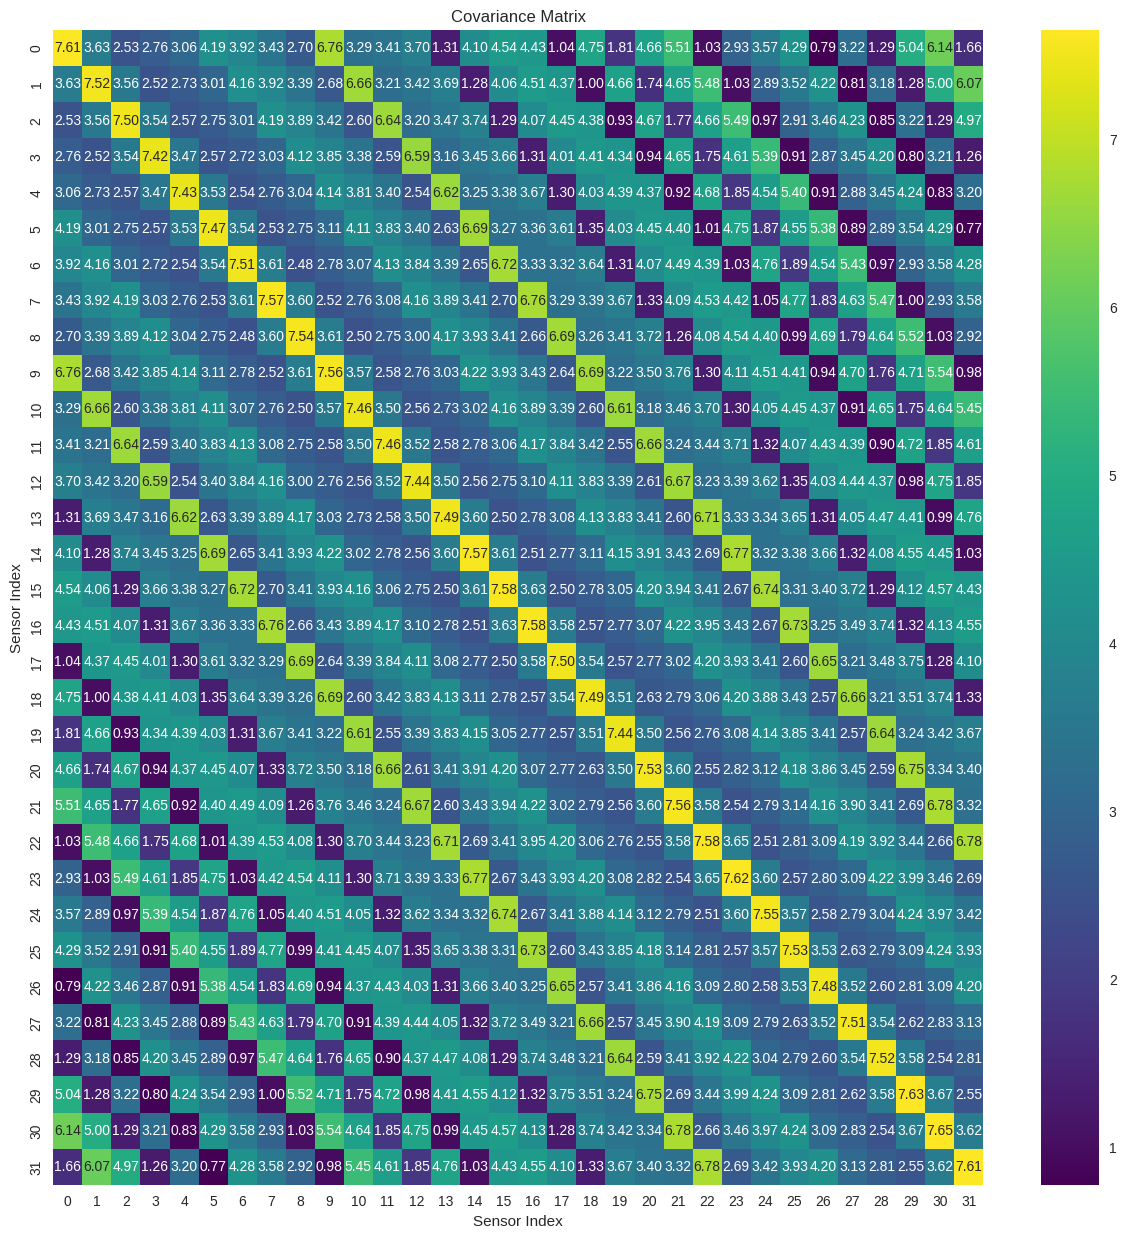

In [105]:
# Plot covariance matrix heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(np.abs(Rxx), annot=True, fmt=".2f", cmap='viridis')
plt.title("Covariance Matrix")
plt.xlabel("Sensor Index")
plt.ylabel("Sensor Index")
plt.show()

## **7. MUSIC DOA Estimation**

The MUSIC spatial spectrum:

$$
P_{\text{MUSIC}}(\theta) = \frac{1}{\mathbf{a}(\theta)^H \mathbf{E}_n \mathbf{E}_n^H \mathbf{a}(\theta)}
$$

Where:
- $\mathbf{a}(\theta)$ — steering vector for angle $\theta$
- $\mathbf{E}_n$ — noise subspace (eigenvectors of smallest eigenvalues of $\mathbf{R}_{xx}$)

In [106]:
# Function for MUSIC DOA Estimation
def music_doa_estimation(X, num_sources, d=0.5, scan_angles=np.arange(-90, 91, 0.1)):
    M, N = X.shape
    Rxx = (X @ X.conj().T) / N
    eigvals, eigvecs = np.linalg.eigh(Rxx)  # eigh for Hermitian
    idx = eigvals.argsort()[::-1]
    eigvecs = eigvecs[:, idx]
    En = eigvecs[:, num_sources:]  # Noise subspace

    P_music = []
    for angle in scan_angles:
        theta = np.deg2rad(angle)
        a = np.exp(-1j * 2 * np.pi * d * np.arange(M) * np.sin(theta)).reshape(-1,1)
        P = 1 / np.abs(a.conj().T @ En @ En.conj().T @ a)
        P_music.append(P[0,0].real)

    return np.array(scan_angles), np.array(P_music)

# Snapshot-Averaged MUSIC Estimation
def snapshot_averaged_music(X, num_sources, N_snapshots=5, scan_angles=np.arange(-90, 91, 0.1)):
    M, total_samples = X.shape
    P_avg = None
    for n in range(N_snapshots):
        start = n*(total_samples//N_snapshots)
        end = (n+1)*(total_samples//N_snapshots)
        X_snap = X[:, start:end]
        _, P_music = music_doa_estimation(X_snap, num_sources, scan_angles=scan_angles)
        if P_avg is None:
            P_avg = P_music
        else:
            P_avg += P_music
    P_avg /= N_snapshots
    return scan_angles, P_avg

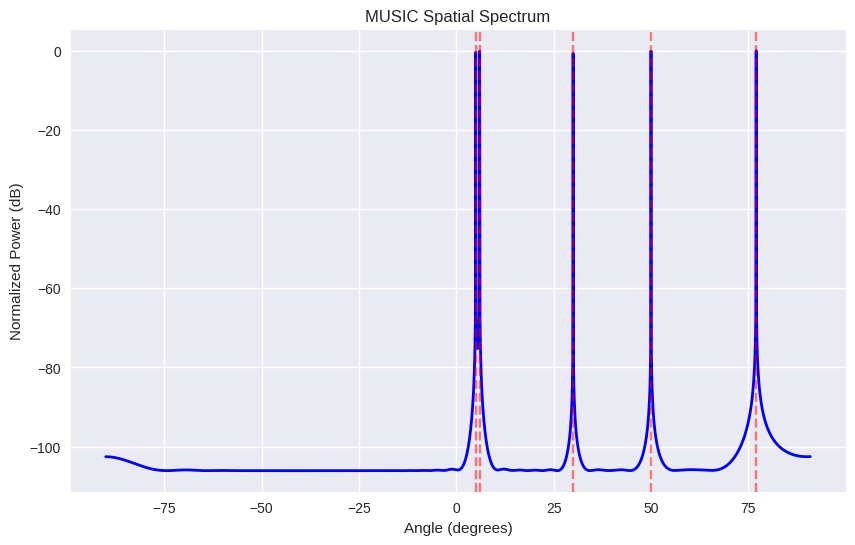

In [107]:
scan_angles, P_music_avg = snapshot_averaged_music(X, num_sources, N_snapshots=50)

# Plot MUSIC Spectrum
plt.figure(figsize=(10,6))
plt.plot(scan_angles, 10*np.log10(P_music_avg/np.max(P_music_avg)), linewidth=2, color='b')
for angle in angles:
    plt.axvline(x=angle, color='r', linestyle='--', alpha=0.5)
plt.title("MUSIC Spatial Spectrum")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Power (dB)")
plt.grid(True)
plt.show()

In [108]:
# Find peaks
peaks, properties = find_peaks(
    P_music_avg,
    height=np.mean(P_music_avg) + 2 * np.std(P_music_avg),  # Adaptive threshold
    distance=20,  # 2° separation
)
estimated_DOAs = scan_angles[peaks]

# Handle missed detections by checking lengths
if len(estimated_DOAs) < len(angles):
    estimated_DOAs = np.append(estimated_DOAs, [0]*(len(angles) - len(estimated_DOAs)))
    print("Warning: Some DOAs were not detected; added zeros for missed detections.")

# Convert to floats and sort
estimated_DOAs_clean = [float(np.round(angle,2)) for angle in estimated_DOAs]
original_DOAs_clean = [float(angle) for angle in angles]

print("Estimated DOAs (degrees):", sorted(estimated_DOAs_clean))
print("Original DOAs (degrees):", sorted(original_DOAs_clean))

Estimated DOAs (degrees): [0.0, 6.0, 30.0, 50.0, 77.0]
Original DOAs (degrees): [5.0, 6.0, 30.0, 50.0, 77.0]


In [109]:
def calculate_rmse_mse(estimated_DOAs_clean, original_DOAs_clean):
    try:
        # Compute RMSE / MSE
        rmse = np.sqrt(np.mean((np.sort(estimated_DOAs_clean) - np.sort(original_DOAs_clean))**2))
        mse = np.mean((np.sort(estimated_DOAs_clean) - np.sort(original_DOAs_clean))**2)
        print(f"RMSE: {rmse:.2f}°, MSE: {mse:.2f}°")
    except ValueError:
        print("Error in RMSE/MSE calculation: Mismatched number of estimated and original DOAs.")

In [110]:
calculate_rmse_mse(estimated_DOAs_clean, original_DOAs_clean)

RMSE: 2.24°, MSE: 5.00°


## **8. Capon (MVDR) DOA Estimation**

Capon (MVDR) spatial spectrum:

$$
P_\text{Capon}(\theta) = \frac{1}{\mathbf{a}(\theta)^H \mathbf{R}_{xx}^{-1} \mathbf{a}(\theta)}
$$
where $\mathbf{R}_{xx}$ is the spatial correlation matrix.

In [111]:
# Function for Capon DOA Estimation
def capon_doa_estimation(X, d=0.5, scan_angles=np.arange(-90,91,0.1)):
    M, N = X.shape
    Rxx = (X @ X.conj().T) / N        # Spatial correlation matrix
    Rxx_inv = np.linalg.pinv(Rxx)     # Pseudo-inverse for stability
    P_capon = []
    for angle in scan_angles:
        theta = np.deg2rad(angle)
        a = np.exp(-1j*2*np.pi*d*np.arange(M)*np.sin(theta)).reshape(-1,1)
        P = 1 / np.real(a.conj().T @ Rxx_inv @ a)
        P_capon.append(P[0,0])
    return np.array(scan_angles), np.array(P_capon)

# Snapshot-Averaged Capon
def snapshot_averaged_capon(X, N_snapshots=5, d=0.5, scan_angles=np.arange(-90,91,0.1)):
    M, total_samples = X.shape
    P_avg = None
    for n in range(N_snapshots):
        start = n*(total_samples//N_snapshots)
        end = (n+1)*(total_samples//N_snapshots)
        X_snap = X[:, start:end]
        _, P = capon_doa_estimation(X_snap, d=d, scan_angles=scan_angles)
        if P_avg is None:
            P_avg = P
        else:
            P_avg += P
    P_avg /= N_snapshots
    return scan_angles, P_avg

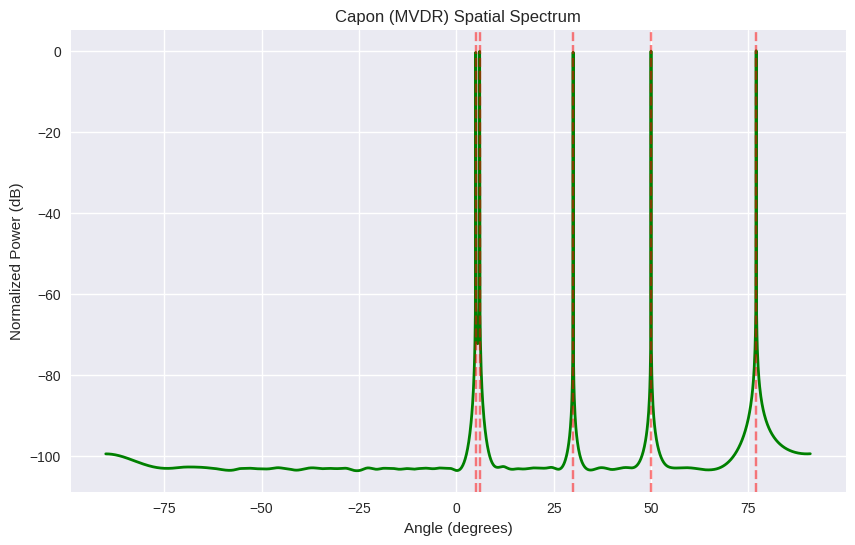

In [112]:
scan_angles, P_capon_avg = snapshot_averaged_capon(X, N_snapshots=50)

# Plot Capon Spectrum
plt.figure(figsize=(10,6))
plt.plot(scan_angles, 10*np.log10(P_capon_avg/np.max(P_capon_avg)), linewidth=2, color='g')
for angle in angles:
    plt.axvline(x=angle, color='r', linestyle='--', alpha=0.5)
plt.title("Capon (MVDR) Spatial Spectrum")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Power (dB)")
plt.grid(True)
plt.show()


In [113]:
# Detect peaks
peaks, properties = find_peaks(
    P_music_avg,
    height=np.mean(P_music_avg) + 2 * np.std(P_music_avg),  # Adaptive threshold
    distance=20,  # 2° separation
)
estimated_DOAs = scan_angles[peaks]

# Handle missed detections by checking lengths
if len(estimated_DOAs) < len(angles):
    estimated_DOAs = np.append(estimated_DOAs, [0]*(len(angles) - len(estimated_DOAs)))
    print("Warning: Some DOAs were not detected; added zeros for missed detections.")

# Sort and convert to floats
estimated_DOAs_clean = [float(np.round(angle,2)) for angle in estimated_DOAs]
original_DOAs_clean = [float(angle) for angle in angles]

print("Estimated DOAs (degrees):", sorted(estimated_DOAs_clean))
print("Original DOAs (degrees):", sorted(original_DOAs_clean))

Estimated DOAs (degrees): [0.0, 6.0, 30.0, 50.0, 77.0]
Original DOAs (degrees): [5.0, 6.0, 30.0, 50.0, 77.0]


In [114]:
# Compute RMSE / MSE
calculate_rmse_mse(estimated_DOAs_clean, original_DOAs_clean)

RMSE: 2.24°, MSE: 5.00°


## **Comparison Between MUSIC and Capon**

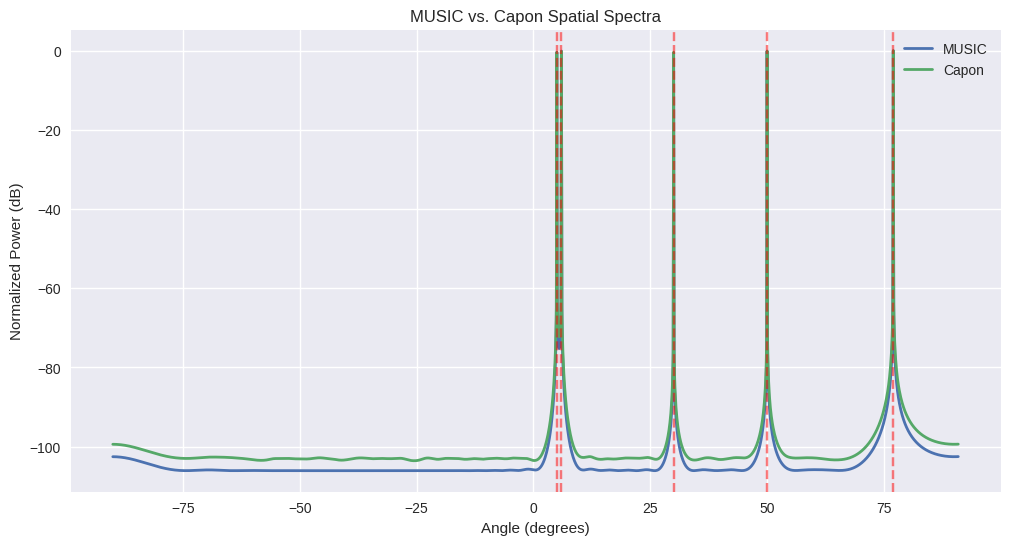

In [115]:
# Plot MUSIC and Capon Spectra Together
plt.figure(figsize=(12, 6))
plt.plot(scan_angles, 10 * np.log10(P_music_avg / np.max(P_music_avg)), label='MUSIC', linewidth=2)
plt.plot(scan_angles, 10 * np.log10(P_capon_avg / np.max(P_capon_avg)), label='Capon', linewidth=2)
for angle in angles:
    plt.axvline(x=angle, color='r', linestyle='--', alpha=0.5)
plt.title("MUSIC vs. Capon Spatial Spectra")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Power (dB)")
plt.legend()
plt.grid(True)
plt.show()